WIND DIRECTION PREDICTION MODEL

Imports

In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import matplotlib.pyplot as plt

Load the Dataset

In [3]:
df = pd.read_csv("../dataset/iSWAI_HistoryData.csv")
df.head()

,name,datetime,temp,humidity,precip,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,stations,source
0,"talisay, daanbantayan, cebu",2022-01-01T00:00:00,25.9,80.56,4.0,43.9,30.2,34.5,1015.0,100.0,NaN,remote,obs
1,"talisay, daanbantayan, cebu",2022-01-01T01:00:00,25.9,81.05,3.8,44.6,28.8,34.2,1014.0,100.0,NaN,remote,obs
2,"talisay, daanbantayan, cebu",2022-01-01T02:00:00,26.1,80.59,2.8,56.9,31.0,40.2,1014.0,100.0,NaN,remote,obs
3,"talisay, daanbantayan, cebu",2022-01-01T03:00:00,26.6,79.20,4.7,43.2,34.2,49.2,1013.0,100.0,NaN,remote,obs
4,"talisay, daanbantayan, cebu",2022-01-01T04:00:00,26.6,79.20,3.1,48.2,38.5,60.7,1013.0,100.0,NaN,remote,obs


Parse datetime + create datetime features
- This is the “include datetime in features” part.

In [4]:
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df = df.sort_values("datetime").reset_index(drop=True)

Basic Time Features

In [6]:
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek
df["month"] = df["datetime"].dt.month
df["day"] = df["datetime"].dt.day

Cyclical encoding 
- better than raw hour/month

In [7]:
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24)

df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

df[["datetime","hour","hour_sin","hour_cos","month_sin","month_cos"]].head()

,datetime,hour,hour_sin,hour_cos,month_sin,month_cos
0,2022-01-01 00:00:00,0,0.000000,1.000000,0.5,0.866025
1,2022-01-01 01:00:00,1,0.258819,0.965926,0.5,0.866025
2,2022-01-01 02:00:00,2,0.500000,0.866025,0.5,0.866025
3,2022-01-01 03:00:00,3,0.707107,0.707107,0.5,0.866025
4,2022-01-01 04:00:00,4,0.866025,0.500000,0.5,0.866025


Convert wind direction to sin/cos target
- Ensure winddir is numeric

In [9]:
df["winddir"] = pd.to_numeric(df["winddir"], errors="coerce")

In [10]:
rad = np.deg2rad(df["winddir"])
df["winddir_sin"] = np.sin(rad)
df["winddir_cos"] = np.cos(rad)

In [11]:
df[["winddir","winddir_sin","winddir_cos"]].head()

,winddir,winddir_sin,winddir_cos
0,34.5,0.566406,0.824126
1,34.2,0.562083,0.827081
2,40.2,0.645458,0.763796
3,49.2,0.756995,0.653421
4,60.7,0.872069,0.489382


Create Strong Lag Features and Rolling Features
- Adding the rolling features, can make These capture short-term patterns and turbulence.

In [12]:
for lag in [1, 2, 3, 6, 12]:
    df[f"wd_sin_lag{lag}"] = df["winddir_sin"].shift(lag)
    df[f"wd_cos_lag{lag}"] = df["winddir_cos"].shift(lag)

    df[f"windspeed_lag{lag}"] = df["windspeed"].shift(lag)

Rolling Features

In [14]:
df["wd_sin_roll3"] = df["winddir_sin"].rolling(3).mean()
df["wd_cos_roll3"] = df["winddir_cos"].rolling(3).mean()

df["windspeed_roll3"] = df["windspeed"].rolling(3).mean()

Create Target (Next Hour)
This means:

Row at 10:00 → predicts windspeed at 11:00

In [15]:
df["target_sin"] = df["winddir_sin"].shift(-1)
df["target_cos"] = df["winddir_cos"].shift(-1)

SELECTION OF FEATURES AND TARGET PREDICTED VARIABLE
- We’ll use your weather columns + datetime features + Create Strong Lag Features + Rolling Features

In [16]:
lag_features = [col for col in df.columns if "lag" in col]
roll_features = [col for col in df.columns if "roll" in col]
time_features = ["hour_sin", "hour_cos", "month_sin", "month_cos"]
feature_cols = ["temp", "humidity", "precip", "windgust", "windspeed",
    "sealevelpressure", "cloudcover"]+ time_features + lag_features + roll_features

In [21]:
use_cols = ["datetime", "target_sin", "target_cos"]  + feature_cols
df2 = df[use_cols].dropna().copy()


In [22]:
X = df2[feature_cols].to_numpy()
y_sin = df2["target_sin"].to_numpy()
y_cos = df2["target_cos"].to_numpy()

In [23]:
df2.shape, X.shape, y_sin.shape, y_cos.shape

((35051, 32), (35051, 29), (35051,), (35051,))

DISPLAY iF DATETIME IS PRESENT!!!!

In [24]:
df2.head()

,datetime,target_sin,target_cos,temp,humidity,precip,windgust,windspeed,sealevelpressure,cloudcover,...,windspeed_lag3,wd_sin_lag6,wd_cos_lag6,windspeed_lag6,wd_sin_lag12,wd_cos_lag12,windspeed_lag12,wd_sin_roll3,wd_cos_roll3,windspeed_roll3
12,2022-01-01 12:00:00,0.675590,0.737277,25.9,86.63,0.4,48.6,41.0,1014.0,100.0,...,34.6,0.835807,0.549023,29.2,0.566406,0.824126,30.2,0.706913,0.705286,38.866667
13,2022-01-01 13:00:00,0.692143,0.721760,25.9,86.63,0.7,49.7,41.8,1013.0,99.9,...,37.1,0.833886,0.551937,32.8,0.562083,0.827081,28.8,0.679779,0.733238,40.433333
14,2022-01-01 14:00:00,0.689620,0.724172,25.8,86.10,1.0,50.4,42.5,1012.0,99.5,...,38.5,0.827081,0.562083,32.8,0.645458,0.763796,31.0,0.678522,0.734450,41.766667
15,2022-01-01 15:00:00,0.681998,0.731354,26.0,83.56,0.2,59.8,44.3,1012.0,97.6,...,41.0,0.777146,0.629320,34.6,0.756995,0.653421,34.2,0.685784,0.727736,42.866667
16,2022-01-01 16:00:00,0.695913,0.718126,26.2,81.58,0.2,61.6,44.3,1012.0,93.8,...,41.8,0.756995,0.653421,37.1,0.872069,0.489382,38.5,0.687920,0.725762,43.700000


Time-Based Split
This avoids leakage from future → past (important for forecasting).

In [25]:
split = int(len(df2) * 0.8)
X_train, X_test = X[:split], X[split:]
ysin_train, ysin_test = y_sin[:split], y_sin[split:]
ycos_train, ycos_test = y_cos[:split], y_cos[split:]

dt_test = df2["datetime"].iloc[split:].reset_index(drop=True)

In [27]:
len(X_train), len(X_test)

(28040, 7011)

TRAIN RANDOM FOREST

In [28]:
rf_sin = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
rf_cos = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)

rf_sin.fit(X_train, ysin_train)
rf_cos.fit(X_train, ycos_train)

rf_sin_pred = rf_sin.predict(X_test)
rf_cos_pred = rf_cos.predict(X_test)

TRAIN XGBOOST

In [29]:
xgb_sin = xgb.XGBRegressor(
    n_estimators=900, learning_rate=0.03, max_depth=6,
    subsample=0.85, colsample_bytree=0.85, random_state=42
)
xgb_cos = xgb.XGBRegressor(
    n_estimators=900, learning_rate=0.03, max_depth=6,
    subsample=0.85, colsample_bytree=0.85, random_state=42
)

xgb_sin.fit(X_train, ysin_train)
xgb_cos.fit(X_train, ycos_train)

xgb_sin_pred = xgb_sin.predict(X_test)
xgb_cos_pred = xgb_cos.predict(X_test)


Ensemble (weighted, based on validation R²)

In [30]:
ens_sin = (rf_sin_pred + xgb_sin_pred) / 2
ens_cos = (rf_cos_pred + xgb_cos_pred) / 2

Convert to Degrees

In [ ]:
 rf_deg = (np.degrees(np.arctan2(rf_sin_pred, rf_cos_pred)) + 360) % 360
 xgb_deg = (np.degrees(np.arctan2(xgb_sin_pred, xgb_cos_pred)) + 360) % 360
 ens_deg = (np.degrees(np.arctan2(ens_sin, ens_cos)) + 360) % 360
 y_true_deg = (np.degrees(np.arctan2(ysin_test, ycos_test)) + 360) % 360
 

Correct Circular Evaluation

In [35]:
def circular_error(y_true, y_pred):
    diff = np.abs(y_true - y_pred)
    return np.minimum(diff, 360 - diff)

def circular_mae(y_true, y_pred):
    return np.mean(circular_error(y_true, y_pred))

def circular_mse(y_true, y_pred):
    err = circular_error(y_true, y_pred)
    return np.mean(err ** 2)

def circular_r2(y_true, y_pred):
    err = circular_error(y_true, y_pred)
    var = np.var(y_true)
    return 1 - np.mean(err ** 2) / var

Results of Evaluation

In [36]:
print("\nRandom Forest")
print("MAE:", circular_mae(y_true_deg, rf_deg))
print("MSE:", circular_mse(y_true_deg, rf_deg))
print("R2 :", circular_r2(y_true_deg, rf_deg))

print("\nXGBoost")
print("MAE:", circular_mae(y_true_deg, xgb_deg))
print("MSE:", circular_mse(y_true_deg, xgb_deg))
print("R2 :", circular_r2(y_true_deg, xgb_deg))

print("\nEnsemble (RF + XGB)")
print("MAE:", circular_mae(y_true_deg, ens_deg))
print("MSE:", circular_mse(y_true_deg, ens_deg))
print("R2 :", circular_r2(y_true_deg, ens_deg))


Random Forest
MAE: 8.761953561915687
MSE: 276.9810101268056
R2 : 0.9694197580328994

XGBoost
MAE: 8.593079551747923
MSE: 256.30590301454606
R2 : 0.9717024046948461

Ensemble (RF + XGB)
MAE: 8.521496694312848
MSE: 260.0189940156127
R2 : 0.9712924588245264


Create results dataframe (datetime + actual + preds)

In [42]:
results = pd.DataFrame({
    "datetime": dt_test,
    "actual_winddirection": y_true_deg,
    "rf_pred": rf_deg,
    "xgb_pred": xgb_deg,
    "ens_pred": ens_deg
})
results.head()

,datetime,actual_winddirection,rf_pred,xgb_pred,ens_pred
0,2025-03-14 20:00:00,41.0,40.658717,39.402344,40.016962
1,2025-03-14 21:00:00,48.5,50.924966,48.518799,49.702102
2,2025-03-14 22:00:00,51.9,52.044529,50.967957,51.506843
3,2025-03-14 23:00:00,51.9,55.481563,54.351624,54.904674
4,2025-03-15 00:00:00,49.0,53.552980,53.839935,53.697516


Plot actual vs ensemble (datetime x-axis)

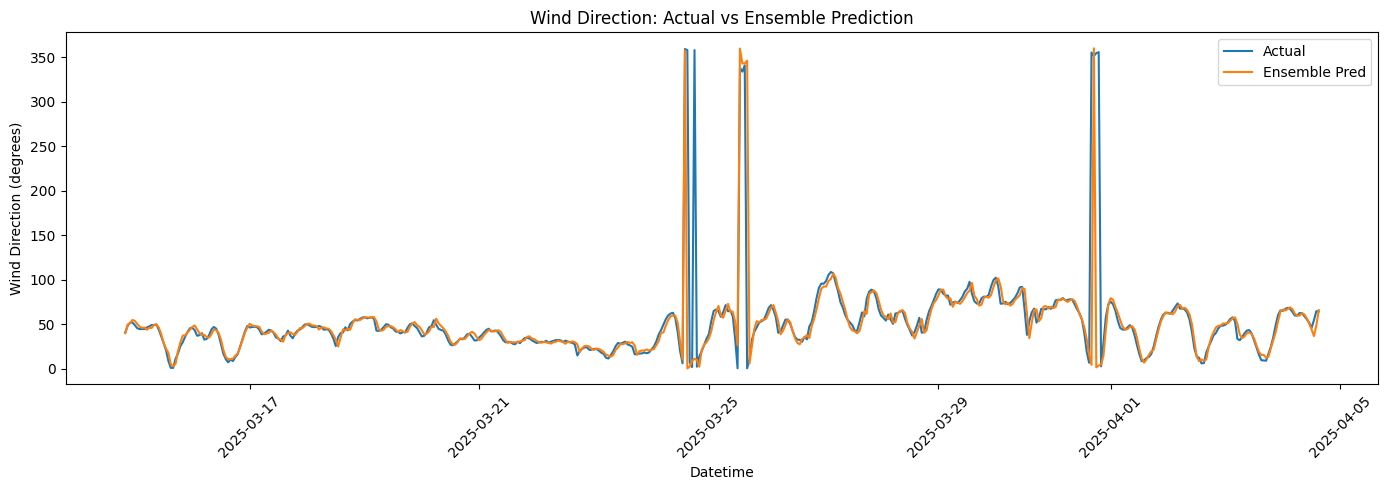

In [39]:
plt.figure(figsize=(14,5))
plot_n = 500  # show first 500 test points
plt.plot(results["datetime"][:plot_n], results["actual_windspeed"][:plot_n], label="Actual")
plt.plot(results["datetime"][:plot_n], results["ens_pred"][:plot_n], label="Ensemble Pred")
plt.title("Wind Direction: Actual vs Ensemble Prediction")
plt.xlabel("Datetime")
plt.ylabel("Wind Direction (degrees)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
import joblib, os
os.makedirs("../server/models", exist_ok=True)

joblib.dump(
    {
        "rf_sin": rf_sin,
        "rf_cos": rf_cos,
        "xgb_sin": xgb_sin,
        "xgb_cos": xgb_cos,
        "feature_cols": feature_cols,
    },
    "../server/models/winddirection_model.joblib"
)

print("Saved: ../server/models/winddirection_model.joblib")

Saved: ../server/models/winddirection_model.joblib
